In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils

import pyaw.utils
from src.pyaw import rotate_vector_by_quaternion

In [2]:
fps = ['./SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius', 'q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
# df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values, df_b_IGRF_clip.index.values))

True

In [6]:
ehx = df_e_clip['Ehx'].values

In [7]:
from src.pyaw import SwarmPreprocess

b_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SCofMAG(df_b_clip['B_NEC'].values, df_b_clip['q_NEC_CRF'].values)
b_sc = b_nec2sc.calculate_rotated_vectors()

b_igrf_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SCofMAG(df_b_IGRF_clip['B_NEC_IGRF'].values,
                                                          df_b_clip['q_NEC_CRF'].values)
b_igrf_sc = b_igrf_nec2sc.calculate_rotated_vectors()

by1 = b_sc[:, 1] - b_igrf_sc[:, 1]

In [8]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = pyaw.utils.time_align_high2low(by1, datetimes_b, datetimes_e)

# dynamic: 06:47:35-06:48:55

In [9]:
st_dy = np.datetime64('2016-03-11T06:47:35')
et_dy = np.datetime64('2016-03-11T06:47:55')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [10]:
from scipy.signal import spectrogram

fs = 16
window = 'hann'
stft_window_seconds = 4
nperseg = int(stft_window_seconds * fs)
noverlap = nperseg // 2

In [11]:
freqs_dy, ts_dy, Sxx_e_dy = spectrogram(ehx_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                        mode='complex')
_, _, Sxx_b_dy = spectrogram(by1_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

Sxx_e_m_dy = np.abs(Sxx_e_dy)
Sxx_b_m_dy = np.abs(Sxx_b_dy)
eb_ratio_dy = Sxx_e_m_dy / Sxx_b_m_dy  # todo:: unit??
# 研究一下spectrogram中的计算过程？

In [14]:
np.max(eb_ratio_dy), np.min(eb_ratio_dy), np.percentile(eb_ratio_dy, 95)

(1176.681313360599, 0.074127299472619, 54.505773976162025)

In [15]:
eb_ratio_bins_dy = np.arange(0, np.percentile(eb_ratio_dy, 95) + 0.2, 0.2)

In [17]:
eb_ratio_histogram2d = pyaw.utils.get_ratio_histogram2d(freqs_dy, eb_ratio_dy, eb_ratio_bins_dy)

In [ ]:
from src.pyaw import mu0

Sigma_P_dy = 3.0
Sigma_P_sta = 0.5

va_dy = 1.4e6
va_sta = 1.3e6

boundary_l_dy = 1 / (mu0 * Sigma_P_dy)
boundary_h_dy = mu0 * va_dy ** 2 * Sigma_P_dy

boundary_l_sta = 1 / (mu0 * Sigma_P_sta)
boundary_h_sta = mu0 * va_sta ** 2 * Sigma_P_sta

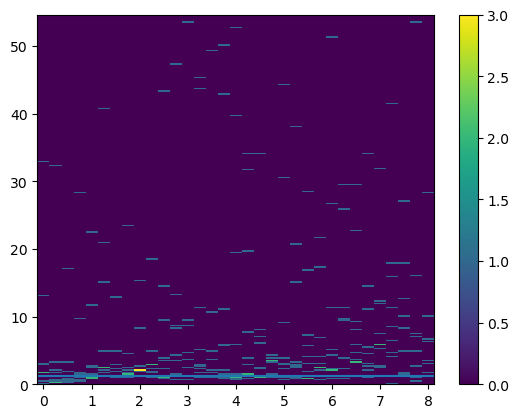

In [18]:
plt.pcolormesh(freqs_dy, (eb_ratio_bins_dy[:-1] + eb_ratio_bins_dy[1:]) / 2, eb_ratio_histogram2d.T)
plt.axhline(1.2)
plt.colorbar()
plt.show()